# CLASSIFICATION

### CLASSIFICATION PLAN:
We collected the labelled data from 2 different origins:
1. **KMeans Clustering** result (which will be called **original data**): 3 distinct classes, one of which is highly **imbalanced**
2. **Fuzzy Kmeans Clustering** result (which will be called **fuzzy data**): 3 distinct classes, not on same magnitude but also not particularly imbalanced

Different approaches will be evaluated:
* Apply classification on original training set i.e. high imbalance in data
* Apply classification on oversampled original training set (robust oversampling method -> SMOTE)
* Apply classification on oversampled original training set and test set (robust oversampling method -> SMOTE)
* Apply classification on fuzzy training set i.e. more balanced data

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pydotplus

from tqdm.notebook import tqdm
from IPython.display import Image 
from collections import Counter
from imblearn.over_sampling import SMOTE
from scipy.stats import randint as sp_randint

from sklearn import tree, metrics
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, make_scorer, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.datasets import make_blobs
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.python.keras.utils.np_utils import to_categorical

***

## UTILITY FUNCTIONS

In [2]:
# transform categorical attributes in numerical 
def discretize_data(dataset, variables):
    for variable in variables:
        #get the unique variable's values
        var = sorted(dataset[variable].unique())
        
        #generate a mapping from the variable's values to the number representation  
        mapping = dict(zip(var, range(0, len(var) + 1)))

        #add a new colum with the number representation of the variable
        dataset[variable+'_num'] = dataset[variable].map(mapping).astype(int)
    return dataset

# pretty printing of metrics computed on test set
def report_scores(test_label, test_pred):
    print(classification_report(test_label, 
                            test_pred, 
                            target_names=classes, zero_division=0)) 
# (to avoid exagerated warnings) zero division = 0 makes sure that no warnings 
# are raised even if no classification on a certain class happens (and it can happen in multiple cases in this notebook)

***

# WORKING ON ORIGINAL DATA

***

In [3]:
# Starting dataset
df = pd.read_csv('../datasets/clustered_dataframe.csv', sep='\t', index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4333 entries, 17850 to 12713
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   TProd           4333 non-null   int64  
 1   DProd           4333 non-null   int64  
 2   MeanProdOrder   4333 non-null   float64
 3   TSale           4333 non-null   float64
 4   MinPSale        4333 non-null   float64
 5   MaxPSale        4333 non-null   float64
 6   MeanSaleOrder   4333 non-null   float64
 7   TRProd          4333 non-null   int64  
 8   MeanPSale       4333 non-null   float64
 9   TOrder          4333 non-null   int64  
 10  SETSaleQta      4333 non-null   float64
 11  SESaleQtaOrder  4333 non-null   float64
 12  MeanTimeGap     4333 non-null   float64
 13  MaxOrderMonth   4333 non-null   object 
 14  MaxOrderDay     4333 non-null   object 
 15  Label           4333 non-null   object 
dtypes: float64(9), int64(4), object(3)
memory usage: 575.5+ KB


In [4]:
# taking a look at data distribution between classes
for label in df['Label'].unique():
    print(label,"elements in dataset:",len(df[df['Label'] == label]))

Low_Spend elements in dataset: 3867
Med_Spend elements in dataset: 440
High_Spend elements in dataset: 26


In [5]:
# we only have 2 categorical attributes, discretize them and get rid of them 
# (also get rid of attributes which lead in our experiments to bad classification)
df = discretize_data(df,['MaxOrderMonth','MaxOrderDay','Label'])
df.drop(columns=['MaxOrderMonth','MaxOrderDay','Label'], inplace=True, errors='ignore')
df.drop(columns=['SETSaleQta','SESaleQtaOrder','MinPSale','MaxPSale'], inplace=True, errors='ignore')
df_class = df.copy()
df_class.tail()

,TProd,DProd,MeanProdOrder,TSale,MeanSaleOrder,TRProd,MeanPSale,TOrder,MeanTimeGap,MaxOrderMonth_num,MaxOrderDay_num,Label_num
CustomerID,,,,,,,,,,,,
13436,76,12,76.0,196.89,196.89,0,5.830,1,0.0,2,3,1
15520,314,18,314.0,343.50,343.50,0,1.724,1,0.0,2,3,1
13298,96,2,96.0,360.00,360.00,0,3.750,1,0.0,2,3,1
14569,79,10,79.0,227.39,227.39,0,3.920,1,0.0,2,3,1
12713,505,37,505.0,794.55,794.55,0,2.085,1,0.0,2,0,2


In [6]:
# we keep true labels apart
label = df_class.pop('Label_num')
# we split dataset in training and test dataset. The use of stratify assures we keep correct class proportions in training and test
train_set, test_set, train_label, test_label = train_test_split(df_class, label, stratify = label, test_size=0.30)

***

## CLASSIFICATION on ORIGINAL TRAINING SET

### Decision Tree (only for illustrating the method, we apply this to make an example of high explainability in classification)

In [7]:
# parameters based on various trial and errors
dt = tree.DecisionTreeClassifier(criterion='gini', splitter='best', 
                                  max_depth=3, 
                                  min_samples_split=3, min_samples_leaf=8)
dt = dt.fit(train_set, train_label)

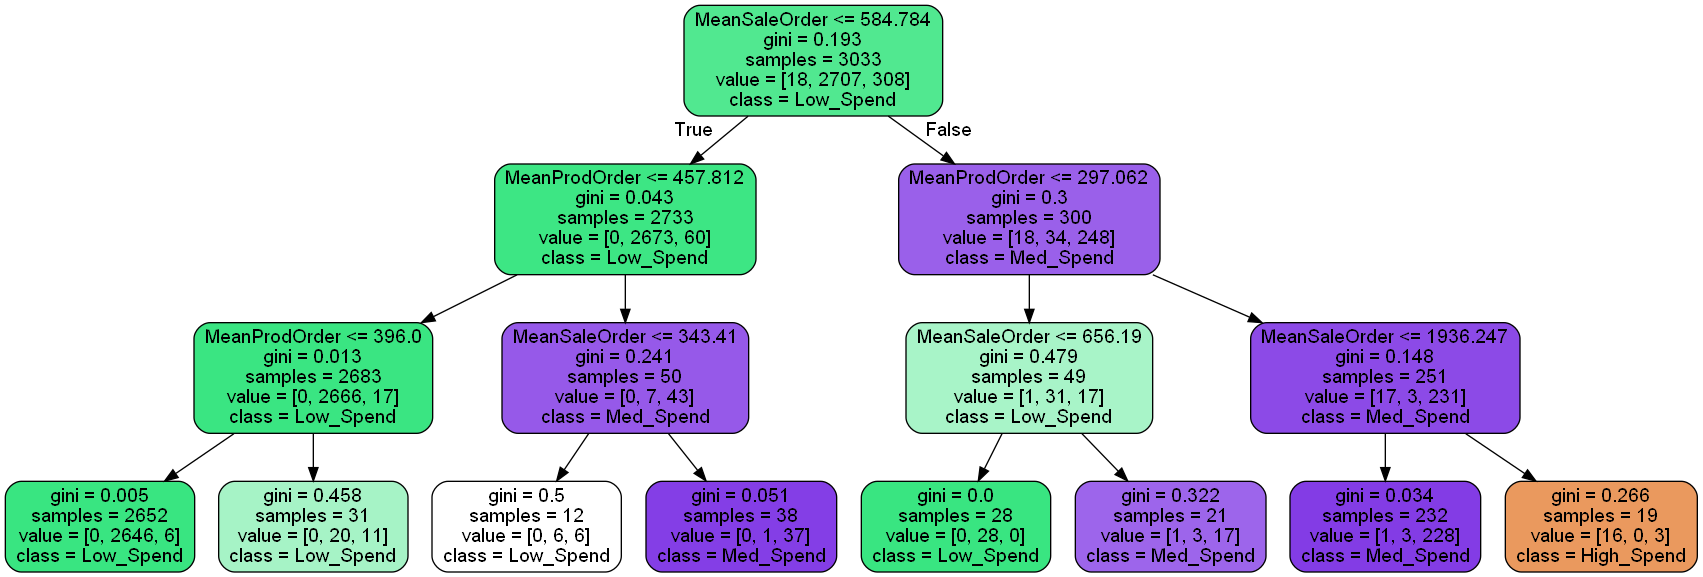

In [8]:
# visualization of dt
classes = ['High_Spend','Low_Spend','Med_Spend']
dot_data = tree.export_graphviz(dt, out_file=None,
                         feature_names=list(train_set.columns),
                         class_names=classes,  #in transforming to numerical this order is mapped to 0,1,2 because of lexicographical
                         filled=True, rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [9]:
# predict and evaluate results on training and test set
train_pred_dt = dt.predict(train_set)
test_pred_dt = dt.predict(test_set)

print('Accuracy training set ', metrics.accuracy_score(train_label, train_pred_dt))
print('Accuracy test set ', metrics.accuracy_score(test_label, test_pred_dt))
print('Precision training set ', metrics.precision_score(train_label, train_pred_dt, average='weighted'))
print('Recall training set ', metrics.recall_score(train_label, train_pred_dt, average='weighted'))
print('F1 score trainig set ', metrics.f1_score(train_label, train_pred_dt, average='weighted'))
print('Support training set ', metrics.precision_recall_fscore_support(train_label, train_pred_dt))

Accuracy training set  0.9884602703593801
Accuracy test set  0.9838461538461538
Precision training set  0.9883835366309135
Recall training set  0.9884602703593801
F1 score trainig set  0.9883333680714669
Support training set  (array([0.84210526, 0.99155343, 0.96907216]), array([0.88888889, 0.99741411, 0.91558442]), array([0.86486486, 0.99447514, 0.94156928]), array([  18, 2707,  308], dtype=int64))


In [10]:
report_scores(test_label, test_pred_dt)

              precision    recall  f1-score   support

  High_Spend       0.58      0.88      0.70         8
   Low_Spend       0.99      1.00      0.99      1160
   Med_Spend       0.95      0.89      0.92       132

    accuracy                           0.98      1300
   macro avg       0.84      0.92      0.87      1300
weighted avg       0.98      0.98      0.98      1300



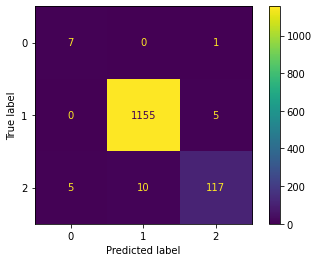

In [11]:
# plot confusion matrix
plot_confusion_matrix(dt, test_set, test_label)
plt.show() 

### Random Forest

**First do a grid search for correct parameter setting**

In [12]:
# define the parameter ranges we want to try, then run the grid search
num_estimators = 30
param_dist = {"max_depth": [3,5,6,7,8,9,10,11,12,None],
              "max_features": sp_randint(1, 10),
              "min_samples_split": sp_randint(3, 20),
              "min_samples_leaf": sp_randint(5, 20),
              "bootstrap": [True, False],
              "criterion": ["entropy", "gini"]}
n_iter_search = 50
clf = RandomForestClassifier(n_estimators=num_estimators)
grid_search = RandomizedSearchCV(clf, param_distributions=param_dist, 
                            n_iter=n_iter_search, 
                            n_jobs=-1, 
                            scoring=make_scorer(accuracy_score))
grid_search.fit(train_set, train_label)

RandomizedSearchCV(estimator=RandomForestClassifier(n_estimators=30), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['entropy', 'gini'],
                                        'max_depth': [3, 5, 6, 7, 8, 9, 10, 11,
                                                      12, None],
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001FA45EE5CA0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001FA45F71220>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001FA45EE5940>},
                   scoring=make_scorer(accuracy_score))

In [13]:
# visualize insights on best performing model individuated
print('Best setting parameters ', grid_search.cv_results_['params'][0])
print('Mean and std of this setting ', grid_search.cv_results_['mean_test_score'][0], 
      grid_search.cv_results_['std_test_score'][0])

Best setting parameters  {'bootstrap': False, 'criterion': 'gini', 'max_depth': 3, 'max_features': 6, 'min_samples_leaf': 8, 'min_samples_split': 16}
Mean and std of this setting  0.9841736397692488 0.0033965499017634443


In [14]:
# set and training the specified random forest
rf = RandomForestClassifier(n_estimators=30, 
                             criterion=grid_search.cv_results_['params'][0]['criterion'],
                             max_features=grid_search.cv_results_['params'][0]['max_features'],
                             max_depth=grid_search.cv_results_['params'][0]['max_depth'], 
                             min_samples_split=grid_search.cv_results_['params'][0]['min_samples_split'],
                             min_samples_leaf=grid_search.cv_results_['params'][0]['min_samples_leaf'],
                             bootstrap=grid_search.cv_results_['params'][0]['bootstrap']) 
rf = rf.fit(train_set, train_label)

In [15]:
# predict on test and visualize results
test_pred_rf = rf.predict(test_set)
report_scores(test_label, test_pred_rf)

              precision    recall  f1-score   support

  High_Spend       0.64      0.88      0.74         8
   Low_Spend       0.99      0.99      0.99      1160
   Med_Spend       0.94      0.92      0.93       132

    accuracy                           0.99      1300
   macro avg       0.86      0.93      0.89      1300
weighted avg       0.99      0.99      0.99      1300



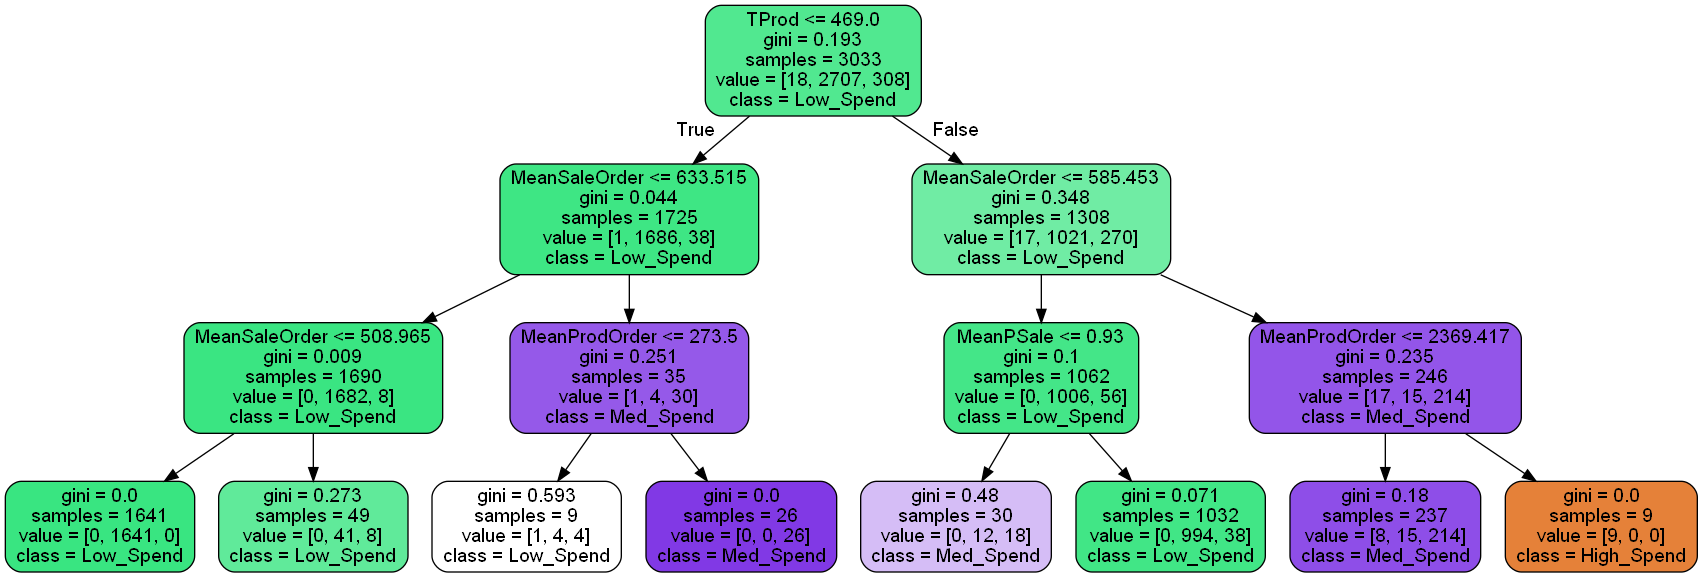

In [16]:
# forest is composed of lots of dt, visualize one just for fun
dot_data = tree.export_graphviz(rf[0], out_file=None,
                         feature_names=list(train_set.columns),
                         class_names=classes,
                         filled=True, rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

### Naive Bayes

In [17]:
# define and fit naive bayes model, predict on test and see results
gnb = GaussianNB()
gnb.fit(train_set, train_label)

test_pred_gnb = gnb.predict(test_set)

report_scores(test_label,test_pred_gnb)

              precision    recall  f1-score   support

  High_Spend       0.53      1.00      0.70         8
   Low_Spend       0.98      0.97      0.97      1160
   Med_Spend       0.74      0.80      0.77       132

    accuracy                           0.95      1300
   macro avg       0.75      0.92      0.81      1300
weighted avg       0.96      0.95      0.95      1300



### KNN

In [18]:
# define and fit knn model, predict on test and see results
knn = KNeighborsClassifier(n_neighbors=5, algorithm='ball_tree', metric='minkowski').fit(train_set, train_label)

test_pred_knn = knn.predict(test_set)

report_scores(test_label,test_pred_knn)

              precision    recall  f1-score   support

  High_Spend       1.00      0.62      0.77         8
   Low_Spend       0.97      0.99      0.98      1160
   Med_Spend       0.90      0.77      0.83       132

    accuracy                           0.97      1300
   macro avg       0.96      0.80      0.86      1300
weighted avg       0.97      0.97      0.97      1300



### SVM

In [19]:
# define and fit svm model, predict on test and see results
svm = SVC(kernel='sigmoid', C=0.6, gamma='scale', probability=True)
svm.fit(train_set, train_label)

test_pred_svm = svm.predict(test_set)

report_scores(test_label, test_pred_svm)

              precision    recall  f1-score   support

  High_Spend       0.00      0.00      0.00         8
   Low_Spend       0.91      1.00      0.95      1160
   Med_Spend       0.84      0.20      0.32       132

    accuracy                           0.91      1300
   macro avg       0.58      0.40      0.42      1300
weighted avg       0.90      0.91      0.88      1300



_Decision Trees_ and _Random Forest_ give the best results, classifing correctly the two major classes and still get good results for High_Spend.

_Naive Bayes_ confirm to be a robust approach getting nice results.

_KNN_ and _SVM_ are not able to well generalized the undersampled class.

***

## CLASSIFICATION on OVERSAMPLED TRAINING SET (SMOTE)

**SMOTE** is a different stratification method which applies oversampling to the classes. The difference between this method and the basic oversampling stands in the generation of new data:
* in the basic oversampling, original data is simply copied to create exact (but additional) new data
* in SMOTE oversampling, original data is used to create new data which copies the old one adding a [0,1] **perturbation**, hence generating truly new data

In [20]:
# create oversampled data
strat = {1: Counter(train_label)[1], 2: Counter(train_label)[2], 0: Counter(train_label)[2] }
smote = SMOTE(
    sampling_strategy=strat,    # resample all classes but the majority one
    k_neighbors=5
)

train_set_smote, train_label_smote = smote.fit_resample(train_set, train_label)

In [21]:
# visualize data distribution
Counter(train_label_smote)

Counter({1: 2707, 2: 308, 0: 308})

### Random Forest

Try grid search again, on this more **balanced** dataset

In [22]:
# define and run the grid search
clf_smote = RandomForestClassifier(n_estimators=num_estimators)
grid_search_smote = RandomizedSearchCV(clf_smote, param_distributions=param_dist, 
                            n_iter=n_iter_search, 
                            n_jobs=-1, 
                            scoring=make_scorer(accuracy_score))
grid_search_smote.fit(train_set_smote, train_label_smote)

RandomizedSearchCV(estimator=RandomForestClassifier(n_estimators=30), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['entropy', 'gini'],
                                        'max_depth': [3, 5, 6, 7, 8, 9, 10, 11,
                                                      12, None],
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001FA45EE5CA0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001FA45F71220>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001FA45EE5940>},
                   scoring=make_scorer(accuracy_score))

In [23]:
# visualize insights on best performing model individuated
print('Best setting parameters ', grid_search_smote.cv_results_['params'][0])
print('Mean and std of this setting ', grid_search_smote.cv_results_['mean_test_score'][0], 
      grid_search_smote.cv_results_['std_test_score'][0])

Best setting parameters  {'bootstrap': True, 'criterion': 'gini', 'max_depth': 3, 'max_features': 8, 'min_samples_leaf': 9, 'min_samples_split': 17}
Mean and std of this setting  0.9816437177280551 0.003210415023458529


In [24]:
# set and training the specified random forest
rf_smote = RandomForestClassifier(n_estimators=num_estimators, 
                             criterion=grid_search_smote.cv_results_['params'][0]['criterion'],
                             max_features=grid_search_smote.cv_results_['params'][0]['max_features'],
                             max_depth=grid_search_smote.cv_results_['params'][0]['max_depth'], 
                             min_samples_split=grid_search_smote.cv_results_['params'][0]['min_samples_split'],
                             min_samples_leaf=grid_search_smote.cv_results_['params'][0]['min_samples_leaf'],
                             bootstrap=grid_search_smote.cv_results_['params'][0]['bootstrap'])
rf_smote = rf_smote.fit(train_set_smote, train_label_smote)

In [25]:
# predict on test and visualize results
test_pred_rf = rf_smote.predict(test_set)
report_scores(test_label, test_pred_rf)

              precision    recall  f1-score   support

  High_Spend       0.58      0.88      0.70         8
   Low_Spend       0.99      1.00      0.99      1160
   Med_Spend       0.95      0.90      0.93       132

    accuracy                           0.99      1300
   macro avg       0.84      0.92      0.87      1300
weighted avg       0.99      0.99      0.99      1300



### Naive Bayes

In [26]:
# define and fit naive bayes model, predict on test and see results
gnb = GaussianNB()
gnb.fit(train_set_smote, train_label_smote)

test_pred_gnb = gnb.predict(test_set)

report_scores(test_label,test_pred_gnb)

              precision    recall  f1-score   support

  High_Spend       0.50      1.00      0.67         8
   Low_Spend       0.98      0.97      0.98      1160
   Med_Spend       0.74      0.80      0.77       132

    accuracy                           0.95      1300
   macro avg       0.74      0.92      0.80      1300
weighted avg       0.96      0.95      0.95      1300



### KNN

In [27]:
# define and fit knn model, predict on test and see results
knn = KNeighborsClassifier(n_neighbors=5, algorithm='ball_tree', metric='minkowski').fit(train_set_smote, train_label_smote)

test_pred_knn = knn.predict(test_set)

report_scores(test_label,test_pred_knn)

              precision    recall  f1-score   support

  High_Spend       0.54      0.88      0.67         8
   Low_Spend       0.97      0.99      0.98      1160
   Med_Spend       0.92      0.73      0.82       132

    accuracy                           0.97      1300
   macro avg       0.81      0.87      0.82      1300
weighted avg       0.97      0.97      0.97      1300



### SVM

In [28]:
# define and fit svm model, predict on test and see results
svm = SVC(kernel='sigmoid', C=0.6, gamma='scale', probability=True)
svm.fit(train_set_smote, train_label_smote)

test_pred_svm = svm.predict(test_set)

report_scores(test_label, test_pred_svm)

              precision    recall  f1-score   support

  High_Spend       0.05      0.62      0.09         8
   Low_Spend       0.91      0.94      0.93      1160
   Med_Spend       1.00      0.01      0.02       132

    accuracy                           0.84      1300
   macro avg       0.65      0.52      0.34      1300
weighted avg       0.92      0.84      0.83      1300



_Random Forest_ and _Naive Bayes_ confirm the previous results.

_KNN_ in this case performs way better.

_SVM_ still they are not to well generalized the undersampled class but in this case we don't get _recall = 0_, but at the same time even the Med_Spend drops significanly.

***

## CLASSIFICATION on OVERSAMPLED TRAINING SET and TEST SET (SMOTE)

Before starting classification we apply stratification to test set to have more data in less populated class.

We do this because otherwise our test set would be populated of < 10 elements for High_Spend class, giving a susceptible evaluation.

In [29]:
strat = {1: Counter(test_label)[1], 2: Counter(test_label)[2], 0: Counter(test_label)[2] }
smote = SMOTE(
    sampling_strategy=strat,    # resample all classes but the majority one
    k_neighbors=5
)
test_set, test_label = smote.fit_resample(test_set, test_label)

In [30]:
# visualize data distribution in TEST
print("Test distribution: ", Counter(test_label))

Test distribution:  Counter({1: 1160, 2: 132, 0: 132})


In [31]:
# visualize data distribution in TRAINING
print("Training distribution: ", Counter(train_label_smote))

Training distribution:  Counter({1: 2707, 2: 308, 0: 308})


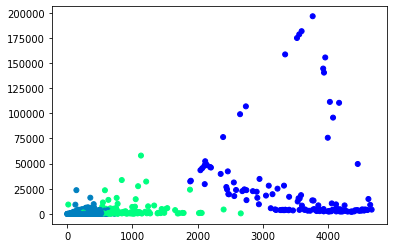

In [32]:
# Training data
plt.scatter(test_set.iloc[:, 4].values, test_set.iloc[:, 0].values, c=test_label.values, s=25, cmap='winter');

### Random Forest

Try grid search again, on this more balanced dataset

In [33]:
# define and run the grid search
clf_smote = RandomForestClassifier(n_estimators=num_estimators)
grid_search_smote = RandomizedSearchCV(clf_smote, param_distributions=param_dist, 
                            n_iter=n_iter_search, 
                            n_jobs=-1, 
                            scoring=make_scorer(accuracy_score))
grid_search_smote.fit(train_set_smote, train_label_smote)

RandomizedSearchCV(estimator=RandomForestClassifier(n_estimators=30), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['entropy', 'gini'],
                                        'max_depth': [3, 5, 6, 7, 8, 9, 10, 11,
                                                      12, None],
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001FA45EE5CA0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001FA45F71220>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001FA45EE5940>},
                   scoring=make_scorer(accuracy_score))

In [34]:
# visualize insights on best performing model individuated
print('Best setting parameters ', grid_search_smote.cv_results_['params'][0])
print('Mean and std of this setting ', grid_search_smote.cv_results_['mean_test_score'][0], 
      grid_search_smote.cv_results_['std_test_score'][0])

Best setting parameters  {'bootstrap': False, 'criterion': 'gini', 'max_depth': 9, 'max_features': 7, 'min_samples_leaf': 7, 'min_samples_split': 14}
Mean and std of this setting  0.9906712564543889 0.00147320810158255


In [35]:
# set and training the specified random forest
rf_smote = RandomForestClassifier(n_estimators=num_estimators, 
                             criterion=grid_search_smote.cv_results_['params'][0]['criterion'],
                             max_features=grid_search_smote.cv_results_['params'][0]['max_features'],
                             max_depth=grid_search_smote.cv_results_['params'][0]['max_depth'], 
                             min_samples_split=grid_search_smote.cv_results_['params'][0]['min_samples_split'],
                             min_samples_leaf=grid_search_smote.cv_results_['params'][0]['min_samples_leaf'],
                             bootstrap=grid_search_smote.cv_results_['params'][0]['bootstrap'])
rf_smote = rf_smote.fit(train_set_smote, train_label_smote)

In [36]:
# predict on test and visualize results
test_pred_rf = rf_smote.predict(test_set)
report_scores(test_label, test_pred_rf)

              precision    recall  f1-score   support

  High_Spend       0.99      0.98      0.99       132
   Low_Spend       1.00      1.00      1.00      1160
   Med_Spend       0.95      0.95      0.95       132

    accuracy                           0.99      1424
   macro avg       0.98      0.98      0.98      1424
weighted avg       0.99      0.99      0.99      1424



### Naive Bayes

In [37]:
# define and fit naive bayes model, predict on test and see results
gnb = GaussianNB()
gnb.fit(train_set_smote, train_label_smote)

test_pred_gnb = gnb.predict(test_set)

report_scores(test_label,test_pred_gnb)

              precision    recall  f1-score   support

  High_Spend       0.94      1.00      0.97       132
   Low_Spend       0.98      0.97      0.98      1160
   Med_Spend       0.74      0.80      0.77       132

    accuracy                           0.96      1424
   macro avg       0.89      0.92      0.91      1424
weighted avg       0.96      0.96      0.96      1424



### KNN

In [38]:
# define and fit knn model, predict on test and see results
knn = KNeighborsClassifier(n_neighbors=5, algorithm='ball_tree', metric='minkowski').fit(train_set_smote, train_label_smote)

test_pred_knn = knn.predict(test_set)

report_scores(test_label,test_pred_knn)

              precision    recall  f1-score   support

  High_Spend       0.95      0.84      0.89       132
   Low_Spend       0.97      0.99      0.98      1160
   Med_Spend       0.78      0.73      0.76       132

    accuracy                           0.96      1424
   macro avg       0.90      0.86      0.88      1424
weighted avg       0.95      0.96      0.95      1424



### SVM

In [39]:
# define and fit svm model, predict on test and see results
svm = SVC(kernel='sigmoid', C=0.6, gamma='scale', probability=True)
svm.fit(train_set_smote, train_label_smote)

test_pred_svm = svm.predict(test_set)

report_scores(test_label, test_pred_svm)

              precision    recall  f1-score   support

  High_Spend       0.46      0.66      0.54       132
   Low_Spend       0.88      0.94      0.91      1160
   Med_Spend       1.00      0.01      0.02       132

    accuracy                           0.83      1424
   macro avg       0.78      0.54      0.49      1424
weighted avg       0.85      0.83      0.79      1424



All the models performs better than the previous section getting higher recalls and f1 score.

_SVM_ still improve in the classification of High_Spend but Med_Spend still remains at a very low recall.

***

# WORKING ON FUZZY DATA

In [40]:
# Starting dataset
df_f = pd.read_csv('../datasets/clustered_fuzzy_dataframe.csv', sep='\t', index_col=0)

In [41]:
# we only have 2 categorical attributes, discretize them and get rid of them 
# (also get rid of attributes which lead in our experiments to bad classification)
df_f = discretize_data(df_f,['MaxOrderMonth','MaxOrderDay','Label'])
df_f.drop(columns=['MaxOrderMonth','MaxOrderDay','Label'], inplace=True, errors='ignore')
df_f.drop(columns=['SETSaleQta','SESaleQtaOrder','MinPSale','MaxPSale'], inplace=True, errors='ignore')
df_f_class = df_f.copy()

In [42]:
# we keep true labels apart
label = df_f_class.pop('Label_num')
# we split dataset in training and test dataset. The use of stratify assures we keep correct class proportions in training and test
train_set_f, test_set_f, train_label_f, test_label_f = train_test_split(df_f_class, label, stratify = label, test_size=0.30)

***

### Decision Tree (only for illustrating the method, we apply this to make an example of high explainability in classification)

In [43]:
# parameters based on various trial and errors
dt_f = tree.DecisionTreeClassifier(criterion='gini', splitter='best', 
                                  max_depth=3, 
                                  min_samples_split=3, min_samples_leaf=8)
dt_f = dt_f.fit(train_set_f, train_label_f)

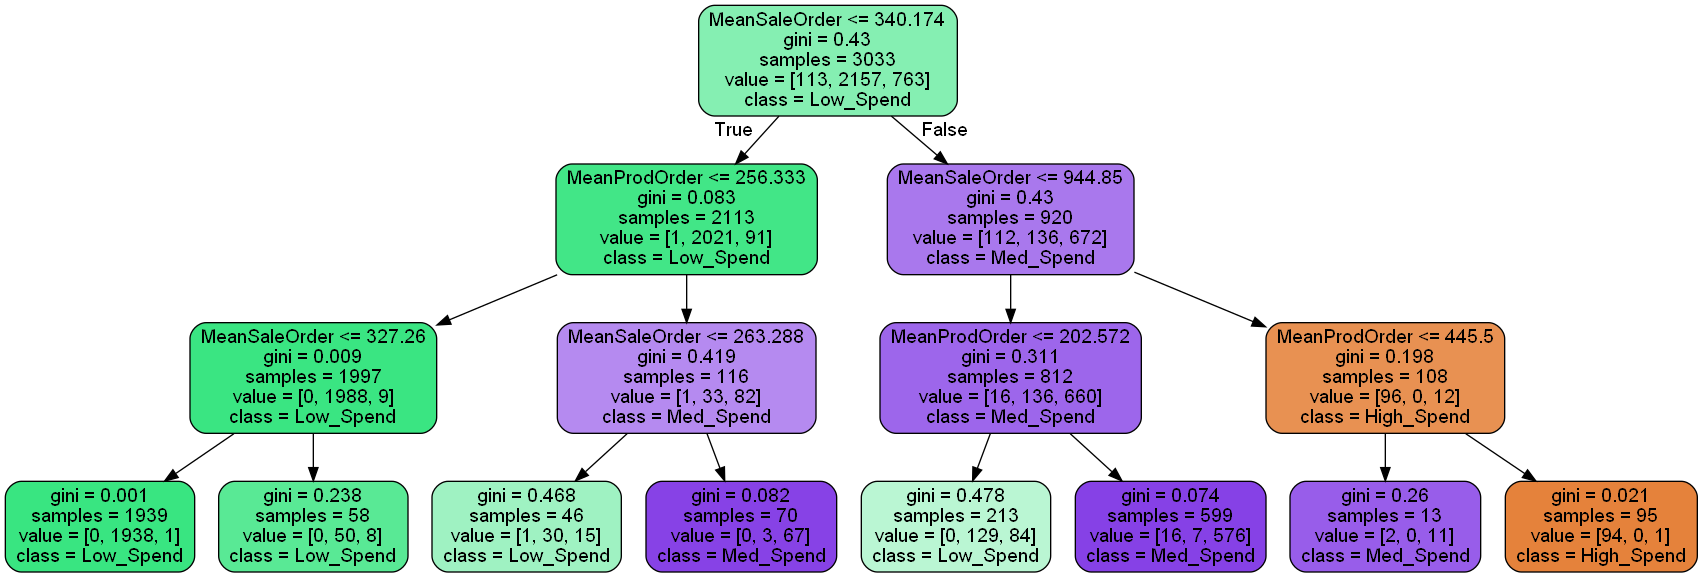

In [44]:
# visualization of dt
dot_data_f = tree.export_graphviz(dt_f, out_file=None,
                         feature_names=list(train_set_f.columns),
                         class_names=classes,  #in transforming to numerical this order is mapped to 0,1,2 because of lexicographical
                         filled=True, rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data_f)
Image(graph.create_png())

In [45]:
# predict on training and test set
train_pred_dt_f = dt_f.predict(train_set_f)
test_pred_dt_f = dt_f.predict(test_set_f)

In [46]:
# visualize results
report_scores(test_label_f, test_pred_dt_f)

              precision    recall  f1-score   support

  High_Spend       1.00      0.79      0.88        48
   Low_Spend       0.95      0.99      0.97       925
   Med_Spend       0.95      0.86      0.91       327

    accuracy                           0.95      1300
   macro avg       0.97      0.88      0.92      1300
weighted avg       0.95      0.95      0.95      1300



### Random Forest

**Do a grid search for correct parameter setting**

In [47]:
# define the parameter ranges we want to try, then run the grid search
clf_f = RandomForestClassifier(n_estimators=30)
grid_search_f = RandomizedSearchCV(clf_f, param_distributions=param_dist, 
                            n_iter=n_iter_search, 
                            n_jobs=-1, 
                            scoring=make_scorer(accuracy_score))
grid_search_f.fit(train_set_f, train_label_f)

RandomizedSearchCV(estimator=RandomForestClassifier(n_estimators=30), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['entropy', 'gini'],
                                        'max_depth': [3, 5, 6, 7, 8, 9, 10, 11,
                                                      12, None],
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001FA45EE5CA0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001FA45F71220>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001FA45EE5940>},
                   scoring=make_scorer(accuracy_score))

In [48]:
# visualize insights on best performing model individuated
print('Best setting parameters ', grid_search_f.cv_results_['params'][0])
print('Mean and std of this setting ', grid_search_f.cv_results_['mean_test_score'][0], 
      grid_search_f.cv_results_['std_test_score'][0])

Best setting parameters  {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 5, 'max_features': 6, 'min_samples_leaf': 19, 'min_samples_split': 3}
Mean and std of this setting  0.9759331452090845 0.008306878990118408


In [49]:
# set and training the specified random forest
rf_f = RandomForestClassifier(n_estimators=num_estimators, 
                             criterion=grid_search_f.cv_results_['params'][0]['criterion'],
                             max_features=grid_search_f.cv_results_['params'][0]['max_features'],
                             max_depth=grid_search_f.cv_results_['params'][0]['max_depth'], 
                             min_samples_split=grid_search_f.cv_results_['params'][0]['min_samples_split'],
                             min_samples_leaf=grid_search_f.cv_results_['params'][0]['min_samples_leaf'],
                             bootstrap=grid_search_f.cv_results_['params'][0]['bootstrap']) 
rf_f = rf_f.fit(train_set_f, train_label_f)

In [50]:
# predict on test and visualize results
test_pred_rf_f = rf_f.predict(test_set_f)
report_scores(test_label_f, test_pred_rf_f)

              precision    recall  f1-score   support

  High_Spend       1.00      0.81      0.90        48
   Low_Spend       0.99      0.99      0.99       925
   Med_Spend       0.95      0.98      0.96       327

    accuracy                           0.98      1300
   macro avg       0.98      0.93      0.95      1300
weighted avg       0.98      0.98      0.98      1300



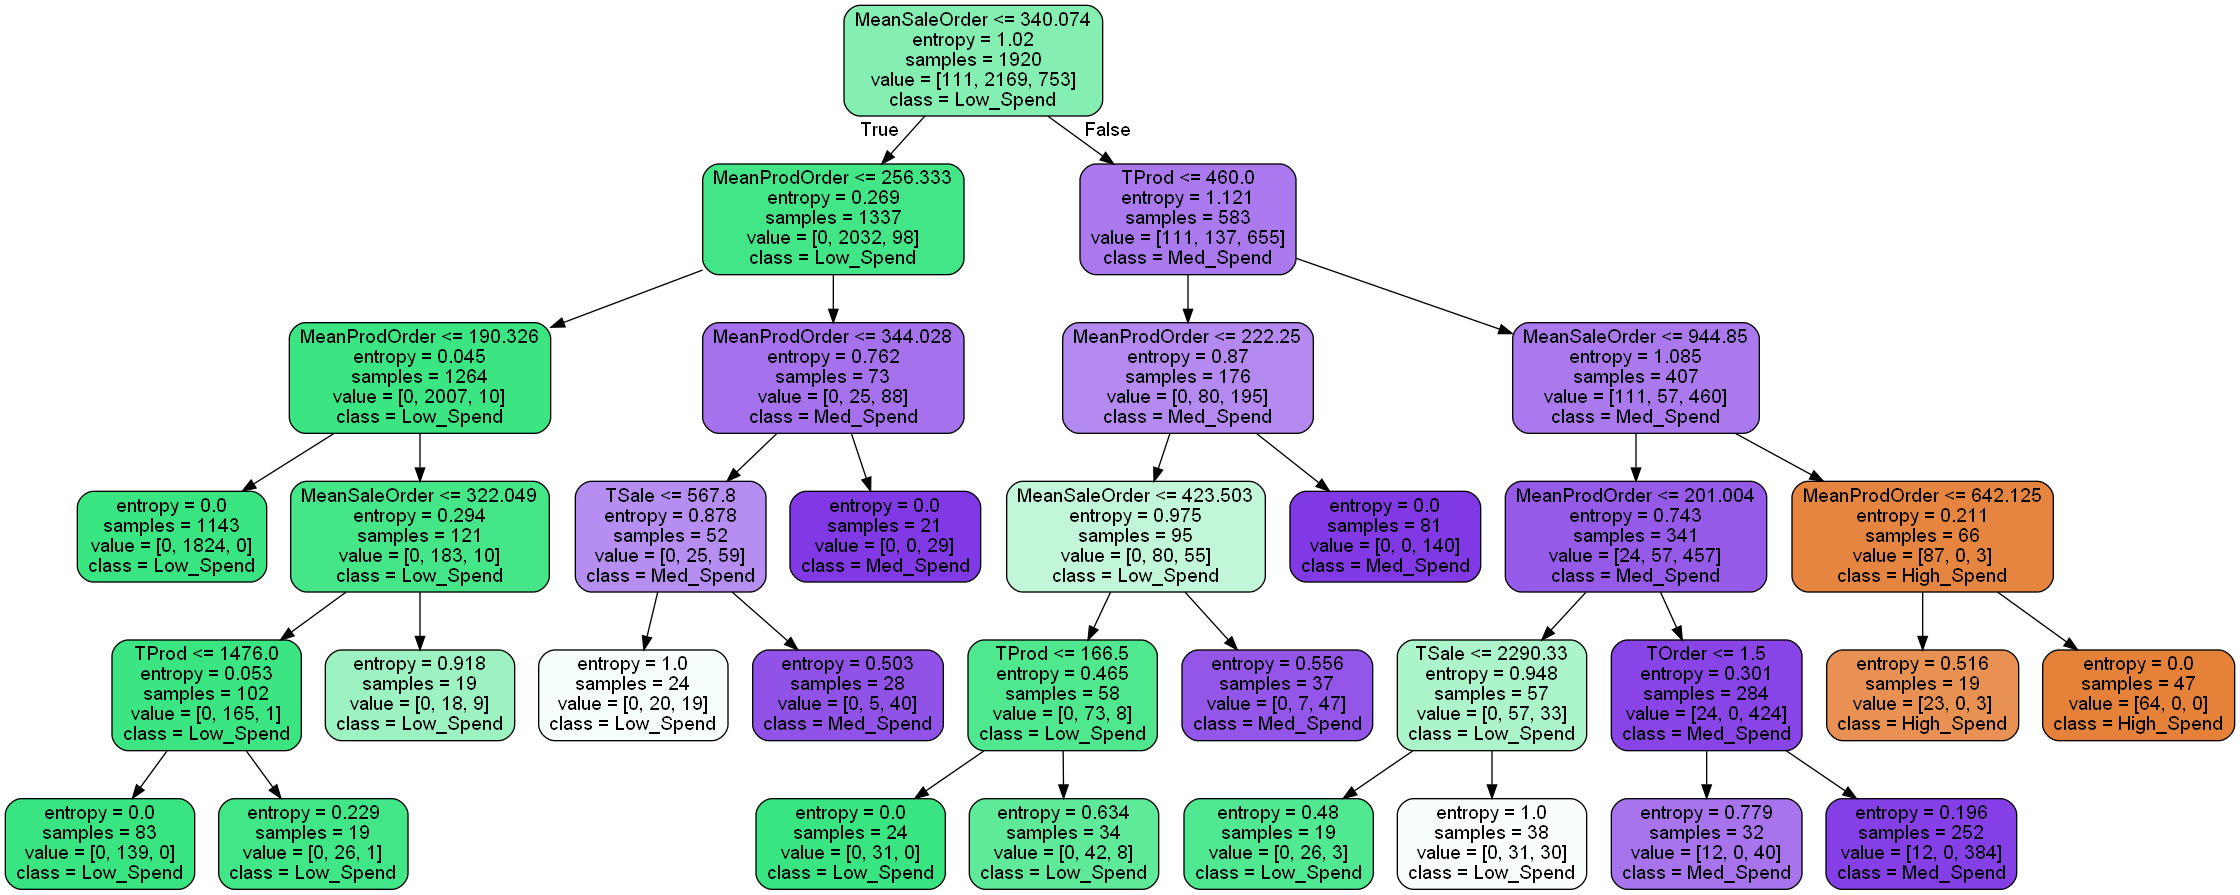

In [51]:
# forest is composed of lots of dt, visualize one just for fun
dot_data_f = tree.export_graphviz(rf_f[0], out_file=None,
                         feature_names=list(train_set_f.columns),
                         class_names=classes,
                         filled=True, rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data_f)
Image(graph.create_png())

### Naive Bayes

In [52]:
# define and fit naive bayes model, predict on test and see results
gnb = GaussianNB()
gnb.fit(train_set_f, train_label_f)

test_pred_gnb = gnb.predict(test_set_f)

report_scores(test_label_f,test_pred_gnb)

              precision    recall  f1-score   support

  High_Spend       0.80      0.75      0.77        48
   Low_Spend       0.94      0.96      0.95       925
   Med_Spend       0.86      0.82      0.84       327

    accuracy                           0.92      1300
   macro avg       0.87      0.84      0.86      1300
weighted avg       0.92      0.92      0.92      1300



### KNN

In [53]:
# define and fit knn model, predict on test and see results
knn = KNeighborsClassifier(n_neighbors=5, algorithm='ball_tree', metric='minkowski').fit(train_set_f, train_label_f)

test_pred_knn = knn.predict(test_set_f)

report_scores(test_label_f,test_pred_knn)

              precision    recall  f1-score   support

  High_Spend       0.88      0.77      0.82        48
   Low_Spend       0.96      0.97      0.96       925
   Med_Spend       0.89      0.86      0.87       327

    accuracy                           0.94      1300
   macro avg       0.91      0.87      0.89      1300
weighted avg       0.94      0.94      0.94      1300



### SVM

In [54]:
# define and fit svm model, predict on test and see results
svm = SVC(kernel='sigmoid', C=0.6, gamma='scale', probability=True)
svm.fit(train_set_f, train_label_f)

test_pred_svm_f = svm.predict(test_set_f)

report_scores(test_label_f, test_pred_svm_f)

              precision    recall  f1-score   support

  High_Spend       0.00      0.00      0.00        48
   Low_Spend       0.79      0.85      0.82       925
   Med_Spend       0.44      0.40      0.42       327

    accuracy                           0.71      1300
   macro avg       0.41      0.42      0.41      1300
weighted avg       0.67      0.71      0.69      1300



With this analysis we can confirm even more the behaviour of the previous sections:
* _Decision Tree_ and _Random Forest_ are the more robust and the ones with better results
* _Naive Bayes_ and _KNN_ with the right number of samples are able to generalize well and get nice results
* _SVM_ still are not able to generalize well the classes

***

# Classification with Neural Network

### Preliminary functions
The following functions are useful in many sections of this notebook, therefore they
are put here at the beginning

In [55]:
# Function to normalize the dataset
def normalize_dataset(df):
    cols = df.columns
    scaler = MinMaxScaler()
    df = scaler.fit_transform(df.values)
    df = pd.DataFrame(df, columns=cols)
    return df

# Function to print the dataset's composition
def print_dataset_composition(train_set, train_labels, test_set, test_labels):
    assert(len(train_set) == len(train_labels))
    assert(len(test_set) == len(test_labels))
    print(f"{len(train_labels)} training samples:")
    print(f"\t- {len(train_labels[train_labels == 0])} samples for the class High_Spend")
    print(f"\t- {len(train_labels[train_labels == 1])} samples for the class Low_Spend")
    print(f"\t- {len(train_labels[train_labels == 2])} samples for the class Med_Spend")
    print(f"\n{len(test_labels)} test samples:")
    print(f"\t- {len(test_labels[test_labels == 0])} samples for the class High_Spend")
    print(f"\t- {len(test_labels[test_labels == 1])} samples for the class Low_Spend")
    print(f"\t- {len(test_labels[test_labels == 2])} samples for the class Med_Spend")
    
# Function to create the NN model
# Creates and returns a Keras NN model
def create_nn(size):
    """
    Characteristics:
        * 4 fully connected layers
            * the first 3 have 32 units
            * the last one has as many units as the number of classes, thus 3

        * activation function:
            * ReLU for the first 3 layers
            * Softmax for the output layer

        * Dropout of 0.2 is applied after every layer
    """
    model = Sequential()
    model.add(Dense(32, activation='relu', input_shape=(1,size)))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(3, activation='softmax'))
    return model

# Function to compile and fit the NN model
def compile_fit(model, training_set, training_labels, epochs):
    """
    Compile and fits the model

    :param training_labels:
    :param training_set:
    :param model: Keras NN model to train
    :return: history of training to plot the metrics
    """
    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    print(training_labels[0])
    hist = model.fit(
        training_set,
        training_labels,
        epochs=epochs,
        batch_size=32,
        validation_split=0.2,
        verbose=1
    )
    return hist

# Function to plot the training results
def plot_train_results(train_history):
    acc = train_history.history['accuracy']
    val_acc = train_history.history['val_accuracy']
    loss = train_history.history['loss']
    val_loss = train_history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'bo', label='Validation Accuracy')
    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro', label='Validation Loss')
    plt.title('Training and validation Acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy & Loss')
    plt.legend()
    plt.grid()
    plt.show()

Labels from _K-means_ clustering algorithm

In [56]:
# Drop categorical columns and keep only the corresponding numerical ones
df.drop(columns=['MaxOrderMonth','Label'], inplace=True, errors='ignore')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4333 entries, 17850 to 12713
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   TProd              4333 non-null   int64  
 1   DProd              4333 non-null   int64  
 2   MeanProdOrder      4333 non-null   float64
 3   TSale              4333 non-null   float64
 4   MeanSaleOrder      4333 non-null   float64
 5   TRProd             4333 non-null   int64  
 6   MeanPSale          4333 non-null   float64
 7   TOrder             4333 non-null   int64  
 8   MeanTimeGap        4333 non-null   float64
 9   MaxOrderMonth_num  4333 non-null   int32  
 10  MaxOrderDay_num    4333 non-null   int32  
 11  Label_num          4333 non-null   int32  
dtypes: float64(5), int32(3), int64(4)
memory usage: 389.3 KB


In [57]:
# Remove the labels from the dataframe and store them in a variable (pandas.Series)
labels = df.pop('Label_num')

<AxesSubplot:>

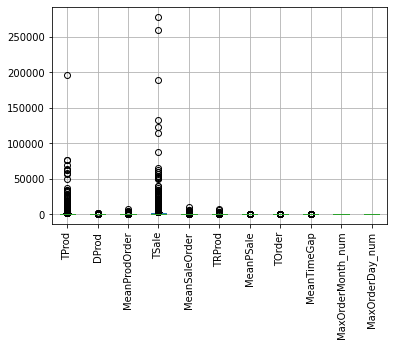

In [58]:
df.boxplot(rot=90)

Normalize the dataset

<AxesSubplot:>

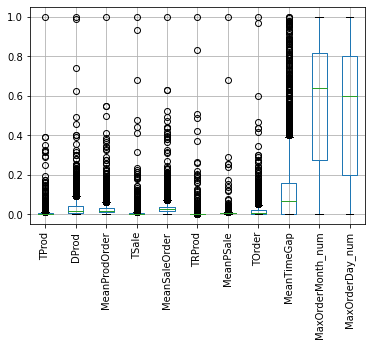

In [59]:
df = normalize_dataset(df)
df.boxplot(rot=90)

Divide the dataframe to create training and testing sets

In [60]:
train_set, test_set, train_labels, test_labels = train_test_split(df, labels, stratify=labels, test_size=0.30)
print_dataset_composition(train_set, train_labels, test_set, test_labels)

3033 training samples:
	- 18 samples for the class High_Spend
	- 2707 samples for the class Low_Spend
	- 308 samples for the class Med_Spend

1300 test samples:
	- 8 samples for the class High_Spend
	- 1160 samples for the class Low_Spend
	- 132 samples for the class Med_Spend


In [61]:
# Encode labels with one-hot
train_labels = to_categorical(train_labels, 3)
test_labels = to_categorical(test_labels, 3)

Create the Neural Network, compile it and train it

In [62]:
nn = create_nn(len(df.columns))
history = compile_fit(nn, train_set, train_labels, epochs=20)

[0. 0. 1.]
Epoch 1/20
76/76 [==============================] - 0s 4ms/step - loss: 0.6325 - accuracy: 0.8710 - val_loss: 0.4082 - val_accuracy: 0.8896
Epoch 2/20
76/76 [==============================] - 0s 2ms/step - loss: 0.4004 - accuracy: 0.8932 - val_loss: 0.3871 - val_accuracy: 0.8896
Epoch 3/20
76/76 [==============================] - 0s 2ms/step - loss: 0.3754 - accuracy: 0.8932 - val_loss: 0.3669 - val_accuracy: 0.8896
Epoch 4/20
76/76 [==============================] - 0s 2ms/step - loss: 0.3545 - accuracy: 0.8932 - val_loss: 0.3402 - val_accuracy: 0.8896
Epoch 5/20
76/76 [==============================] - 0s 2ms/step - loss: 0.3316 - accuracy: 0.8932 - val_loss: 0.3151 - val_accuracy: 0.8896
Epoch 6/20
76/76 [==============================] - 0s 2ms/step - loss: 0.3088 - accuracy: 0.8932 - val_loss: 0.2826 - val_accuracy: 0.8896
Epoch 7/20
76/76 [==============================] - 0s 2ms/step - loss: 0.2763 - accuracy: 0.8937 - val_loss: 0.2450 - val_accuracy: 0.8896
Epoch 8/2

Plot the training results:

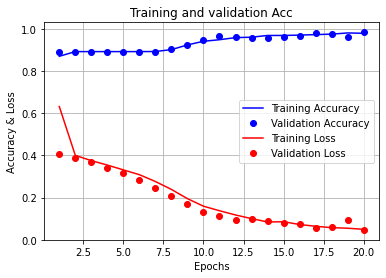

In [63]:
plot_train_results(history)

Test the model on the test set

In [64]:
test_predictions = nn.predict_classes(test_set)
test_predictions = to_categorical(test_predictions, 3)
report_scores(test_labels, test_predictions)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
              precision    recall  f1-score   support

  High_Spend       1.00      0.75      0.86         8
   Low_Spend       1.00      1.00      1.00      1160
   Med_Spend       0.98      0.96      0.97       132

   micro avg       0.99      0.99      0.99      1300
   macro avg       0.99      0.90      0.94      1300
weighted avg       0.99      0.99      0.99      1300
 samples avg       0.99      0.99      0.99      1300



Base dataframe with SMOTE oversampling

Labels come from _K-Means_ clustering algorithm

### Normalize and SMOTE

In [65]:
#Normalize the dataset
cols = df.columns
scaler = MinMaxScaler()
df = scaler.fit_transform(df.values)
df = pd.DataFrame(df, columns=cols)

# Pick validation set from the complete df
df, val_set, labels, val_labels = train_test_split(df, labels, stratify=labels, test_size=0.30)

# Divide the dataframe to create training and testing sets
train_set, test_set, train_labels, test_labels = train_test_split(df, labels, stratify=labels, test_size=0.30)

# SMOTE --> balance the number of entries of each class
smote = SMOTE(
    sampling_strategy='not majority',    # resample all classes but the majority one
    k_neighbors=4
)
train_set, train_labels = smote.fit_resample(train_set, train_labels)
test_set, test_labels = smote.fit_resample(test_set, test_labels)

assert(len(train_set) == len(train_labels))
assert(len(val_set) == len(val_labels))
assert(len(test_set) == len(test_labels))
print(f"\n{len(train_labels)} training samples:")
print(f"\t- {len(train_labels[train_labels == 0])} samples for the class High_Spend")
print(f"\t- {len(train_labels[train_labels == 1])} samples for the class Low_Spend")
print(f"\t- {len(train_labels[train_labels == 2])} samples for the class Med_Spend")
print(f"\n{len(test_labels)} validation samples:")
print(f"\t- {len(val_labels[val_labels == 0])} samples for the class High_Spend")
print(f"\t- {len(val_labels[val_labels == 1])} samples for the class Low_Spend")
print(f"\t- {len(val_labels[val_labels == 2])} samples for the class Med_Spend")
print(f"\n{len(test_labels)} test samples:")
print(f"\t- {len(test_labels[test_labels == 0])} samples for the class High_Spend")
print(f"\t- {len(test_labels[test_labels == 1])} samples for the class Low_Spend")
print(f"\t- {len(test_labels[test_labels == 2])} samples for the class Med_Spend")

# Encode labels with one-hot
train_labels = to_categorical(train_labels, 3)
val_labels = to_categorical(val_labels, 3)
test_labels = to_categorical(test_labels, 3)


5685 training samples:
	- 1895 samples for the class High_Spend
	- 1895 samples for the class Low_Spend
	- 1895 samples for the class Med_Spend

2436 validation samples:
	- 8 samples for the class High_Spend
	- 1160 samples for the class Low_Spend
	- 132 samples for the class Med_Spend

2436 test samples:
	- 812 samples for the class High_Spend
	- 812 samples for the class Low_Spend
	- 812 samples for the class Med_Spend


Create the Neural Network, compile it and train it

In [66]:
nn = Sequential([
    Dense(16, activation='relu'),
    Dropout(0.5),
    Dense(16, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

nn.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
history = nn.fit(
    train_set,
    train_labels,
    epochs=27,
    batch_size=32,
    validation_data=(val_set, val_labels),
    verbose=1
)

Epoch 1/27

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

178/178 [==============================] - 0s 2ms/step - loss: 1.0585 - accuracy: 0.4047 - val_loss: 1.0122 - val_accuracy: 0.6200
Epoch 2/27
178/178 [==============================] - 0s 1ms/step - loss: 0.8628 - accuracy: 0.5664 - val_loss: 0.8288 - val_accuracy: 0.8746
Epoch 3/27
178/178 [==============================] - 0s 1ms/step - loss: 0.6986 - accuracy: 0.6392 - val_loss: 0.7183 - val_accuracy: 0.9154
Epoch 4/27
178/178 [==============================] - 0s 1ms/step - loss: 0.6088 -

Plot the training results:

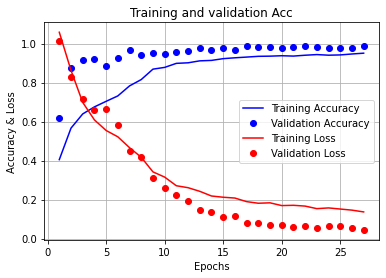

In [67]:
plot_train_results(history)

Test the model on the test set

In [68]:
test_predictions = nn.predict_classes(test_set)
test_predictions = to_categorical(test_predictions, 3)
report_scores(test_labels, test_predictions)


              precision    recall  f1-score   support

  High_Spend       1.00      1.00      1.00       812
   Low_Spend       1.00      0.99      1.00       812
   Med_Spend       0.99      1.00      0.99       812

   micro avg       1.00      1.00      1.00      2436
   macro avg       1.00      1.00      1.00      2436
weighted avg       1.00      1.00      1.00      2436
 samples avg       1.00      1.00      1.00      2436



***

Labels from _Fuzzy C-Means_ clustering algorithm

In [69]:
# Remove the labels from the dataframe and store them in a variable (pandas.Series)
labels = df_f.pop('Label_num')

#Normalize the dataset
df_f = normalize_dataset(df_f)

# Divide the dataframe to create training and testing sets
train_set, test_set, train_labels, test_labels = train_test_split(df_f, labels, stratify=labels, test_size=0.30)
print_dataset_composition(train_set, train_labels, test_set, test_labels)

# Encode labels with one-hot
train_labels = to_categorical(train_labels, 3)
test_labels = to_categorical(test_labels, 3)

3033 training samples:
	- 113 samples for the class High_Spend
	- 2157 samples for the class Low_Spend
	- 763 samples for the class Med_Spend

1300 test samples:
	- 48 samples for the class High_Spend
	- 925 samples for the class Low_Spend
	- 327 samples for the class Med_Spend


Create the Neural Network, compile it and train it

In [70]:
nn = create_nn(len(df_f.columns))
history = compile_fit(nn, train_set, train_labels, epochs=20)

[1. 0. 0.]
Epoch 1/20
76/76 [==============================] - 0s 3ms/step - loss: 0.8129 - accuracy: 0.7045 - val_loss: 0.7042 - val_accuracy: 0.7133
Epoch 2/20
76/76 [==============================] - 0s 2ms/step - loss: 0.7250 - accuracy: 0.7090 - val_loss: 0.6729 - val_accuracy: 0.7133
Epoch 3/20
76/76 [==============================] - 0s 1ms/step - loss: 0.6971 - accuracy: 0.7090 - val_loss: 0.6338 - val_accuracy: 0.7133
Epoch 4/20
76/76 [==============================] - 0s 1ms/step - loss: 0.6449 - accuracy: 0.7119 - val_loss: 0.5725 - val_accuracy: 0.7150
Epoch 5/20
76/76 [==============================] - 0s 1ms/step - loss: 0.5794 - accuracy: 0.7362 - val_loss: 0.4934 - val_accuracy: 0.7414
Epoch 6/20
76/76 [==============================] - 0s 1ms/step - loss: 0.4937 - accuracy: 0.7786 - val_loss: 0.4044 - val_accuracy: 0.7875
Epoch 7/20
76/76 [==============================] - 0s 1ms/step - loss: 0.4380 - accuracy: 0.8104 - val_loss: 0.3266 - val_accuracy: 0.8682
Epoch 8/2

Plot the training results:

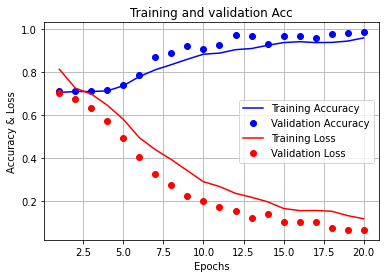

In [71]:
plot_train_results(history)

Test the model on the test set

In [72]:
test_predictions = nn.predict_classes(test_set)
test_predictions = to_categorical(test_predictions, 3)
report_scores(test_labels, test_predictions)

              precision    recall  f1-score   support

  High_Spend       1.00      0.88      0.93        48
   Low_Spend       0.99      0.98      0.98       925
   Med_Spend       0.92      0.98      0.95       327

   micro avg       0.97      0.97      0.97      1300
   macro avg       0.97      0.94      0.96      1300
weighted avg       0.98      0.97      0.97      1300
 samples avg       0.97      0.97      0.97      1300



As expected the big guns didn't let us down.

***

# Alternative Features

For this analysis the dataset *customer_dataframe_big.csv* will be used, since it contains all the features for the customers.
Then, joining with the dataset created from Fuzzy K-Means we add the labeling to the various customers.   

In [73]:
df = pd.read_csv('../datasets/clustered_fuzzy_dataframe.csv', sep='\t', index_col=0)
df_customer = pd.read_csv('../datasets/customer_dataframe_big.csv', sep='\t', index_col=0)

df_customer.set_index("CustomerID", inplace = True)
df_customer['Label'] = df['Label']

# Size of different classes in the dataset
print("-------------------------")
for i in ['Low_Spend', 'Med_Spend', 'High_Spend']:
    print(i, len(df_customer[df_customer['Label'] == i]))

-------------------------
Low_Spend 3082
Med_Spend 1090
High_Spend 161


The target of this analysis is to use all the features that are not exploited by the clustering to assign the customers to a class.

In [74]:
# Drop all the features that are not time dependent and not usefull to generalize the behaviour of a customer
df_customer = discretize_data(df_customer,['MaxOrderMonth','Label'])
df_aux = df_customer.drop(columns=['TProd', 'MaxPO', 'MinPO', 'MeanProdOrder', 'TSaleWRet', 'MinPSale', 'MaxPSale', 'MeanSaleOrder',
                                   'MeanPSale', 'MaxOrderMonth', 'MaxOrderMonth', 'MaxOrderDay', 'Label', 'TRProd', 
                                   'SETSaleQta', 'SESaleQtaOrder', 'SEShoppingDays', 'DProd', 'TSale', 'TOrder'], errors='ignore')
df_class = df_aux.copy()
df_class.tail()

,OrderMonth,ProdMonth,SaleMonth,MonthPresence,MeanTimeGap,MaxOrderMonth_num,Label_num
CustomerID,,,,,,,
13436,0.083,6.333,16.407,0.083,0.0,2,1
15520,0.083,26.167,28.625,0.083,0.0,2,2
13298,0.083,8.000,30.000,0.083,0.0,2,1
14569,0.083,6.583,18.949,0.083,0.0,2,1
12713,0.083,42.083,66.212,0.083,0.0,2,2


## Decision Tree

In [75]:
label = df_class.pop('Label_num')
train_set, test_set, train_label, test_label = train_test_split(df_class, label, stratify =label, test_size=0.35)
print(f"Class HighSpend\nTraining: {len(train_label[train_label == 0])}\nTest: {len(test_label[test_label == 0])}")

Class HighSpend
Training: 105
Test: 56


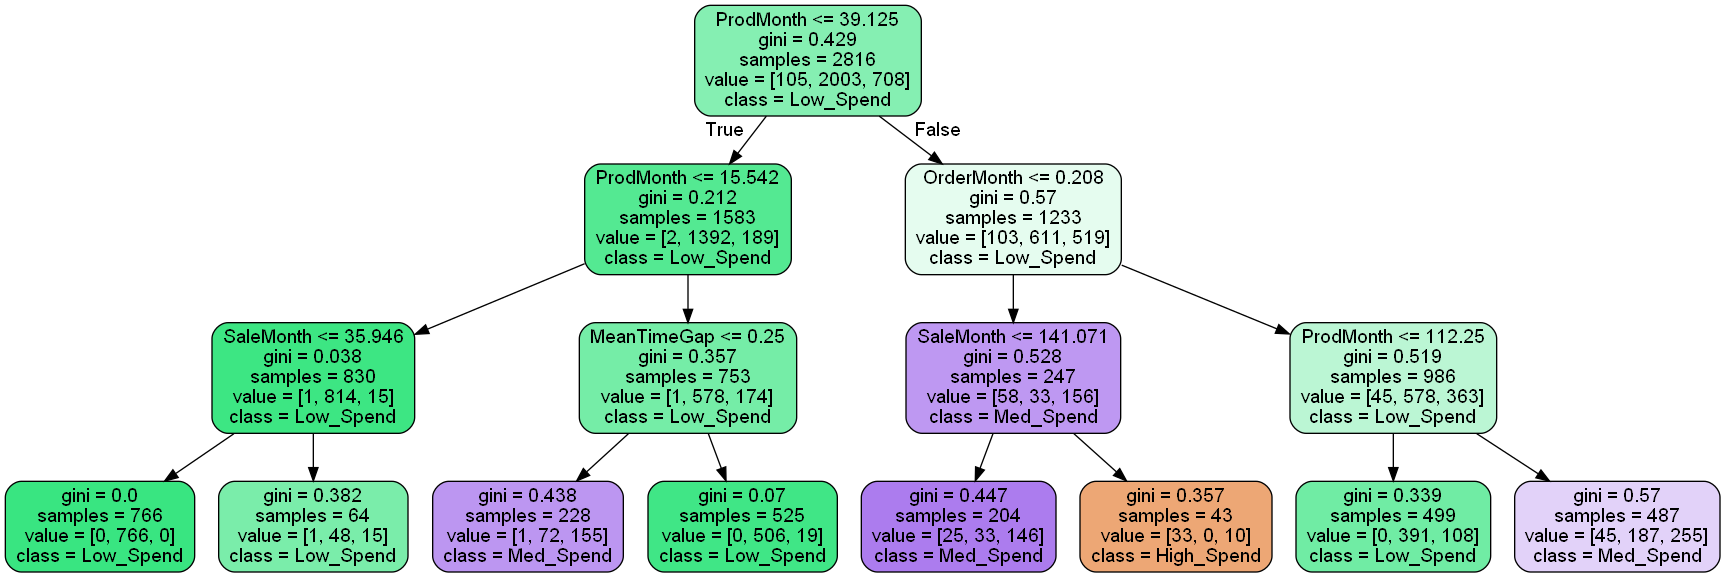

In [76]:
dt = tree.DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=3, min_samples_split=17, min_samples_leaf=20)
dt = dt.fit(train_set, train_label)
classes = ['High_Spend','Low_Spend','Med_Spend']
dot_data = tree.export_graphviz(dt, out_file=None, feature_names=list(train_set.columns), class_names=classes, filled=True, rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [77]:
train_pred_dt = dt.predict(train_set)
test_pred_dt = dt.predict(test_set)
report_scores(test_label, test_pred_dt)

              precision    recall  f1-score   support

  High_Spend       0.57      0.21      0.31        56
   Low_Spend       0.90      0.83      0.86      1079
   Med_Spend       0.55      0.73      0.63       382

    accuracy                           0.78      1517
   macro avg       0.67      0.59      0.60      1517
weighted avg       0.80      0.78      0.78      1517



***